In [ ]:
# import modules for data preprocessing & qwen

from transformers import AutoModelForCausalLM, AutoTokenizer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import h5py

import wandb

import tempfile


# Implement modules for LoRA skeleton

import math

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from accelerate import Accelerator

from itertools import cycle
import gc
import os

In [ ]:
# check gpu
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Mar 30 19:49:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   52C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# load data

with h5py.File("code\lotka_volterra_data.h5","r") as f:

    # access the full dataset
    # dataset has format [model, time_points, predator/prey]
    # dataset has dimensions [1000, 100, 2]

    trajectories = f["trajectories"][:]
    time_points = f["time"][:]

    # access a single trajectory
    system_id = 0 # first system

    # first 100 time points
    prey = trajectories[system_id, :, 0]
    predator = trajectories[system_id, :, 1]
    times = time_points[:]

    # whole dataset

    prey_all = trajectories[:, :, 0]
    predator_all = trajectories[:, :, 1]
    expanded_times = np.tile(times, (1000, 1))  # Repeat along a new axis

In [ ]:
# define scaling & inverse scaling of dataset

# For inital scaling do [data, data, inv = False]
# For inverse scaling do [scaled data, data, inv = True]

def scaling(x, data, alpha=0.95, inv = bool):

    """
    Args:
        data (array-like) - dataset to derive scaling from
        x (array-like) - data to be transformed
        alpha (float) - quantile for scaling (alpha = 0.95) corresponds to 95% of the data lying in the range [0,1]
        inv (boolean) - whether performing transformation (False) or inverse transformation (True)

    """
    q = np.maximum(np.quantile(np.abs(data), alpha), .01) #avoids scaling by values < 0.001

    if inv == False:
      return x / q

    else:
        return x * np.array(q)

In [ ]:
# pre-process data

#scaling
data = scaling([prey_all,predator_all], [prey_all, predator_all], alpha=0.5, inv=False)

# [:, trajectory][pred/prey]
# tokenize entire dataset (encoding)
tokenize_whole_dataset = [
    ";".join(f"{x:.2f},{y:.2f}" for x, y in zip(prey_row, predator_row))
    for prey_row, predator_row in zip(data[:,:][0], data[:,:][1])
]

In [ ]:
# split into training (80%), test (10%) & validation (10%)

train = tokenize_whole_dataset[0:800]
test = tokenize_whole_dataset[900:1000]
val = tokenize_whole_dataset[800:900]

In [ ]:
# Trimming function
def trim_arrays(arrays, target_length):
    trimmed_arrays = []
    for arr in arrays:

        # Keep only the first 799 entries
        trimmed_entries = arr[:target_length]

        trimmed_arrays.append(trimmed_entries)

    return trimmed_arrays

def trim_arrays_neg(arrays, target_length):
    trimmed_arrays = []
    for arr in arrays:

        # Keep only the first 799 entries
        trimmed_entries = arr[target_length:]

        trimmed_arrays.append(trimmed_entries)

    return trimmed_arrays

# Trim the arrays
test_input = trim_arrays(test, target_length=799)

inputs = test_input



In [ ]:
# Qwen model & tokenizer

def load_qwen():
    model_name = "Qwen/Qwen2.5-0.5B-Instruct"
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)

    # Freeze all parameters except LM head bias
    for param in model.parameters():
        param.requires_grad = False

    # Add trainable bias to logits
    assert model.lm_head.bias is None
    model.lm_head.bias = torch.nn.Parameter(
        torch.zeros(model.config.vocab_size, device=model.device)
    )
    model.lm_head.bias.requires_grad = True

    return model, tokenizer

In [ ]:
# LoRA implementation

class LoRALinear(nn.Module):
    def __init__(self, original_linear: nn.Linear, r: int, alpha: int = None):
        super().__init__()
        assert isinstance(original_linear, nn.Linear)
        self.original_linear = original_linear
        self.original_linear.weight.requires_grad = False
        if self.original_linear.bias is not None:
            self.original_linear.bias.requires_grad = False
        in_dim = original_linear.in_features
        out_dim = original_linear.out_features
        self.r = r
        self.alpha = alpha if alpha else r

        device = original_linear.weight.device
        self.A = nn.Parameter(torch.empty(r, in_dim, device=device))
        self.B = nn.Parameter(torch.zeros(out_dim, r, device=device))

        # Initialise A with He initialization
        nn.init.kaiming_normal_(self.A, nonlinearity="linear")

    def forward(self, x):
        base_out = self.original_linear(x)
        lora_out = (x @ self.A.T) @ self.B.T
        return base_out + lora_out * (self.alpha / self.r)


# load model & tokenizer


model, tokenizer = load_qwen()

lora_rank = 4

# Actually apply LoRA to the model:
for layer in model.model.layers:
    layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=lora_rank)
    layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=lora_rank)
# ^These are the parts that will actually be trained!
lora_params = (p for p in model.parameters() if p.requires_grad)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

In [ ]:
# generate text predictions from Qwen

def generate_predictions(prompt, model):

    decoded_output = []
    outputs = []

    max_new_tokens = 200
    device = next(model.parameters()).device  # Get the model's device

    for i in range(len(prompt)):

        inputs = tokenizer(prompt[i], return_tensors="pt").to(device)

        output = model.generate(**inputs, max_new_tokens=max_new_tokens)

        outputs.append(output)

        decoded_output.append(tokenizer.decode(output[0]))

    return decoded_output

In [ ]:
# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Model is on {next(model.parameters()).device}")  # Check device

Model is on cuda:0


In [ ]:
# Process the data into sequences of text
train_texts, val_texts = train, val

# ^Each of these is a `list[str]` representing contiguous parts of the time series,
#  in text form (using the LLMTIME scheme).

In [ ]:
# Modified tokenization with chunking
def process_sequences(texts, tokenizer, max_length, stride):
    all_input_ids = []
    for text in texts:
        # Apply Qwen's tokenization scheme to the text:
        encoding = tokenizer(text, return_tensors="pt", add_special_tokens=False)
        seq_ids = encoding.input_ids[0]

        # Create sliding windows to further divide the data into chunks:
        for i in range(0, len(seq_ids), stride):
            chunk = seq_ids[i : i + max_length]
            if len(chunk) < max_length:
                chunk = torch.cat(
                    [
                        chunk,
                        torch.full((max_length - len(chunk),), tokenizer.pad_token_id),
                    ]
                )
            all_input_ids.append(chunk)
    return torch.stack(all_input_ids)

In [ ]:
def train_model_grad_accum(train_texts, model, tokenizer, batch_size, lora_rank, max_ctx_length,
                learning_rate, num_steps, grad_accum_steps, project_name, name_run):

    if wandb.run is None:
        wandb.init(project=project_name, name=name_run, config={
            "batch_size": batch_size,
            "lora_rank": lora_rank,
            "learning_rate": learning_rate,
            "num_steps": num_steps,
            "grad_accum_steps": grad_accum_steps
        })

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    print('Running on device:', device)

    # Tokenize training set
    train_input_ids = process_sequences(train_texts, tokenizer, max_ctx_length,
                                        stride=max_ctx_length // 2)
    train_dataset = TensorDataset(train_input_ids)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              pin_memory=False, num_workers=0)  # MPS safe


    # Tokenize validation set
    val_input_ids = process_sequences(val_texts, tokenizer, max_ctx_length,
                                      stride=max_ctx_length)  # use full stride for val
    val_dataset = TensorDataset(val_input_ids)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            pin_memory=False, num_workers=0)



    # Optimizer
    optimizer = torch.optim.Adam(lora_params, lr=learning_rate)

    # Accelerator (no mixed_precision on MPS)
    accelerator = Accelerator(mixed_precision="no")
    model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

    print("Beginning training loop...")
    model.train()
    steps, loss_train = 0, []
    train_iterator = cycle(train_loader)
    training_bar = tqdm(total=num_steps, desc="Training")

    accum_loss = 0.0

    # Validation interval (every 100 training steps)
    val_interval = 100
    val_loss_history = []

    while steps < num_steps:
        for _ in range(grad_accum_steps):
            (batch,) = next(train_iterator)
            batch = batch.to(device)

            outputs = model(batch, labels=batch)
            loss = outputs.loss / grad_accum_steps

            accelerator.backward(loss)
            accum_loss += loss.item()

# Optimizer step after accumulating gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

        steps += 1
        loss_train.append(accum_loss)
        training_bar.update(1)
        training_bar.set_postfix(loss=accum_loss)


        wandb.log({"train_loss": accum_loss, "step": steps})
        accum_loss = 0.0

        # Periodic validation evaluation
        if steps % val_interval == 0:
            model.eval()
            total_val_loss = 0.0
            num_val_batches = 0

            with torch.no_grad():
                for (val_batch,) in val_loader:
                    val_batch = val_batch.to(device)
                    val_outputs = model(val_batch, labels=val_batch)
                    total_val_loss += val_outputs.loss.item()
                    num_val_batches += 1

            avg_val_loss = total_val_loss / num_val_batches if num_val_batches > 0 else 0.0
            val_loss_history.append(avg_val_loss)
            wandb.log({"val_loss": avg_val_loss, "step": steps})
            print(f"\nStep {steps}: Validation Loss = {avg_val_loss:.4f}\n")
            model.train()

        if steps % 100 == 0:
            gc.collect()
            if torch.backends.mps.is_available():
                torch.mps.empty_cache()


    # Create a temporary directory for model saving
    with tempfile.TemporaryDirectory() as tmp_dir:
        model.save_pretrained(tmp_dir)

        # Upload the entire directory as a wandb artifact
        artifact = wandb.Artifact(name=name_run, type="model")
        artifact.add_dir(tmp_dir)  # Add the entire directory
        wandb.log_artifact(artifact)


    training_bar.close()
    wandb.finish()
    print(f"Training finished at {steps} steps. Final loss: {loss_train[-1]:.4f}")

    # Final cleanup
    model.eval()
    if torch.backends.mps.is_available():
        torch.mps.empty_cache()
    gc.collect()

    return model, loss_train, val_loss_history

In [ ]:
# train the model - change hyperparameters here

trained_model, loss, val = train_model_grad_accum(train_texts, model, tokenizer, batch_size=4, lora_rank=4, max_ctx_length=512,
                learning_rate=1e-5, num_steps=1000, grad_accum_steps=1, project_name="hyperparameter_search_report", name_run="lr1e5_LoRA_rank4_overfitonepercent")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cjm267 (cjm267-university-of-cambridge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Running on device: cuda
Beginning training loop...


Training:  10%|█         | 100/1000 [01:01<09:17,  1.61it/s, loss=1.95] 


Step 100: Validation Loss = 1.0393



Training:  20%|██        | 200/1000 [02:28<08:11,  1.63it/s, loss=0.862]


Step 200: Validation Loss = 0.9565



Training:  30%|███       | 300/1000 [03:55<07:07,  1.64it/s, loss=0.581]


Step 300: Validation Loss = 0.7453



Training:  40%|████      | 400/1000 [05:22<06:07,  1.63it/s, loss=0.525]


Step 400: Validation Loss = 0.6830



Training:  50%|█████     | 500/1000 [06:49<05:06,  1.63it/s, loss=0.494]


Step 500: Validation Loss = 0.6491



Training:  60%|██████    | 600/1000 [08:16<04:06,  1.63it/s, loss=0.47]


Step 600: Validation Loss = 0.6233



Training:  70%|███████   | 700/1000 [09:43<03:03,  1.63it/s, loss=0.447]


Step 700: Validation Loss = 0.5996



Training:  80%|████████  | 800/1000 [11:10<02:02,  1.63it/s, loss=0.429]


Step 800: Validation Loss = 0.5824



Training:  90%|█████████ | 900/1000 [12:37<01:01,  1.63it/s, loss=0.414]


Step 900: Validation Loss = 0.5707



Training: 100%|██████████| 1000/1000 [14:04<00:00,  1.63it/s, loss=0.401]


Step 1000: Validation Loss = 0.5616



wandb: Adding directory to artifact (/tmp/tmppt3zw097)... Done. 9.5s
Training: 100%|██████████| 1000/1000 [14:46<00:00,  1.13it/s, loss=0.401]


step,▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train_loss,█▇▃▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▃▂▂▂▁▁▁
step,1000
train_loss,0.40109
val_loss,0.56164


Training finished at 1000 steps. Final loss: 0.4011


In [ ]:
# generate some example predictions using the test set inputs

decoded_output = generate_predictions(inputs, model=trained_model)

In [ ]:
# inspect outputs

decoded_output

['1.45,1.17;1.03,1.36;0.68,1.33;0.49,1.15;0.40,0.93;0.38,0.74;0.41,0.59;0.49,0.48;0.62,0.41;0.81,0.38;1.07,0.39;1.38,0.44;1.67,0.58;1.78,0.82;1.58,1.14;1.13,1.39;0.72,1.40;0.48,1.22;0.38,0.99;0.35,0.77;0.37,0.60;0.44,0.48;0.56,0.40;0.74,0.36;1.00,0.36;1.32,0.40;1.66,0.51;1.86,0.73;1.74,1.07;1.29,1.39;0.80,1.48;0.50,1.32;0.37,1.07;0.33,0.83;0.33,0.64;0.39,0.50;0.49,0.41;0.65,0.35;0.89,0.33;1.21,0.35;1.58,0.44;1.89,0.62;1.93,0.94;1.54,1.33;0.97,1.55;0.57,1.45;0.38,1.19;0.31,0.92;0.30,0.70;0.33,0.54;0.41,0.42;0.55,0.35;0.75,0.31;1.04,0.31;1.42,0.36;1.82,0.49;2.06,0.74;1.87,1.16;1.28,1.54;0.72,1.60;0.42,1.37;0.30,1.07;0.27,0.81;0.28,0.61;0.33,0.46;0.43,0.37;0.59,0.31;0.84,0.28;1.18,0.30;1.61,0.37;2.03,0.53;2.18,0.87;1.77,1.37;1.05,1.69;0.55,1.60;0.33,1.30;0.25,0.98;0.24,0.73;0.26,0.54;0.33,0.41;0.43,0.33;0.58,0.31;0.81,0.31;1.16,0.31;1.58,0.38;1.95,0.51;2.12,0.75;1.90,1.13;1.27,1.56;0.74,1.63;0.46,1.38;0.34,1.07;0.31,0.80;0.30,0.62;0.34,0.48;0.43,0.40;0.58,0.32;0.82,0.31;1.18,0.31;1.60,0.3

In [ ]:
# convert de-tokenized sequence into original pairwise points
def parse_data(data_str):
    """Converts a semicolon-separated string of comma-separated values into a list of tuples."""
    return [tuple(map(float, pair.split(','))) for pair in data_str.split(';')]

preds = []

for i in range(len(decoded_output)):
    preds.append(parse_data(decoded_output[i]))

print(preds)

# scaled data in prey array & predator array
predictions = []

for i in range(len(decoded_output)):

    prey_preds_scaled = [x for x,y in preds[i]]
    predator_preds_scaled = [y for x,y in preds[i]]

    # unscale data
    predictions.append(scaling([prey_preds_scaled, predator_preds_scaled], [prey_all, predator_all], inv=True))



[[(1.45, 1.17), (1.03, 1.36), (0.68, 1.33), (0.49, 1.15), (0.4, 0.93), (0.38, 0.74), (0.41, 0.59), (0.49, 0.48), (0.62, 0.41), (0.81, 0.38), (1.07, 0.39), (1.38, 0.44), (1.67, 0.58), (1.78, 0.82), (1.58, 1.14), (1.13, 1.39), (0.72, 1.4), (0.48, 1.22), (0.38, 0.99), (0.35, 0.77), (0.37, 0.6), (0.44, 0.48), (0.56, 0.4), (0.74, 0.36), (1.0, 0.36), (1.32, 0.4), (1.66, 0.51), (1.86, 0.73), (1.74, 1.07), (1.29, 1.39), (0.8, 1.48), (0.5, 1.32), (0.37, 1.07), (0.33, 0.83), (0.33, 0.64), (0.39, 0.5), (0.49, 0.41), (0.65, 0.35), (0.89, 0.33), (1.21, 0.35), (1.58, 0.44), (1.89, 0.62), (1.93, 0.94), (1.54, 1.33), (0.97, 1.55), (0.57, 1.45), (0.38, 1.19), (0.31, 0.92), (0.3, 0.7), (0.33, 0.54), (0.41, 0.42), (0.55, 0.35), (0.75, 0.31), (1.04, 0.31), (1.42, 0.36), (1.82, 0.49), (2.06, 0.74), (1.87, 1.16), (1.28, 1.54), (0.72, 1.6), (0.42, 1.37), (0.3, 1.07), (0.27, 0.81), (0.28, 0.61), (0.33, 0.46), (0.43, 0.37), (0.59, 0.31), (0.84, 0.28), (1.18, 0.3), (1.61, 0.37), (2.03, 0.53), (2.18, 0.87), (1.7

In [ ]:
# NLL calculations

nll = []

for i in range(len(decoded_output)):

    # set bad tokens to have terrible softmax odds
    batch = tokenizer(
        [decoded_output[i]],
        return_tensors="pt"
    )
    batch = {k: v.to(trained_model.device) for k, v in batch.items()}

    with torch.no_grad():
        out = trained_model(**batch)


    good_tokens_str = list("0123456789,;")
    good_tokens = [tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]
    bad_tokens = [i for i in range(len(tokenizer)) if i not in good_tokens]
    out['logits'][:,:,bad_tokens] = -100

    input_ids = batch['input_ids'][0][1:]
    logprobs = torch.nn.functional.log_softmax(out['logits'], dim=-1)[0][:-1]
    logprobs = logprobs[torch.arange(len(input_ids)), input_ids].cpu().numpy()

    tokens = tokenizer.batch_decode(
        input_ids
    )

    input_len = len(tokenizer([decoded_output[i][0:799]], return_tensors="pt",)['input_ids'][0])

    logprobs = logprobs[input_len:]
    tokens = tokens[input_len:]
    BPD = -logprobs.sum()/len(decoded_output[i][800:])

    print("BPD", BPD)
    # log p(x) = log p(token) - log bin_width = log p(token) + prec * log base
    transformed_nll = BPD - 2 * np.log(10)

    q = 3.47384
    avg_logdet_dydx = - np.log(q)

    print("NLL/D:", transformed_nll-avg_logdet_dydx )

    nll.append(transformed_nll-avg_logdet_dydx)

BPD 23.888622
NLL/D: 20.528712708286623
BPD 23.98991
NLL/D: 20.630000550083498
BPD 24.03902
NLL/D: 20.679110962681154
BPD 23.852009
NLL/D: 20.492099243931154
BPD 23.881323
NLL/D: 20.52141328506885
BPD 23.884224
NLL/D: 20.524314362339357
BPD 23.768295
NLL/D: 20.408385712437013
BPD 23.595428
NLL/D: 20.23551889114795
BPD 23.942192
NLL/D: 20.582282501987795
BPD 23.8621
NLL/D: 20.502191025547365
BPD 23.713573
NLL/D: 20.353663880161623
BPD 23.853806
NLL/D: 20.493895966343263
BPD 23.874386
NLL/D: 20.51447625809131
BPD 23.965252
NLL/D: 20.605342346958498
BPD 23.871418
NLL/D: 20.511508423618654
BPD 23.761587
NLL/D: 20.401677567295412
BPD 23.695812
NLL/D: 20.335902649692873
BPD 23.763657
NLL/D: 20.403747040562013
BPD 23.947989
NLL/D: 20.588078934482912
BPD 23.991299
NLL/D: 20.631389099888185


In [ ]:
# MAE calculations

mae_prey = []
mae_pred = []

for i in range(len(decoded_output)):

    mae_prey_temp = 1/len(decoded_output) * np.sum(np.abs(predictions[i][0][-20:] - prey_all[-i][-20:]))
    mae_pred_temp = 1/len(decoded_output) * np.sum(np.abs(predictions[i][1][-20:] - predator_all[-i][-20:]))

    mae_prey.append(mae_prey_temp)
    mae_pred.append(mae_pred_temp)


mae = np.sum(mae_pred + mae_prey)/(2*len(decoded_output))


print('average MAE =', mae)

average MAE = 3.345046450256929


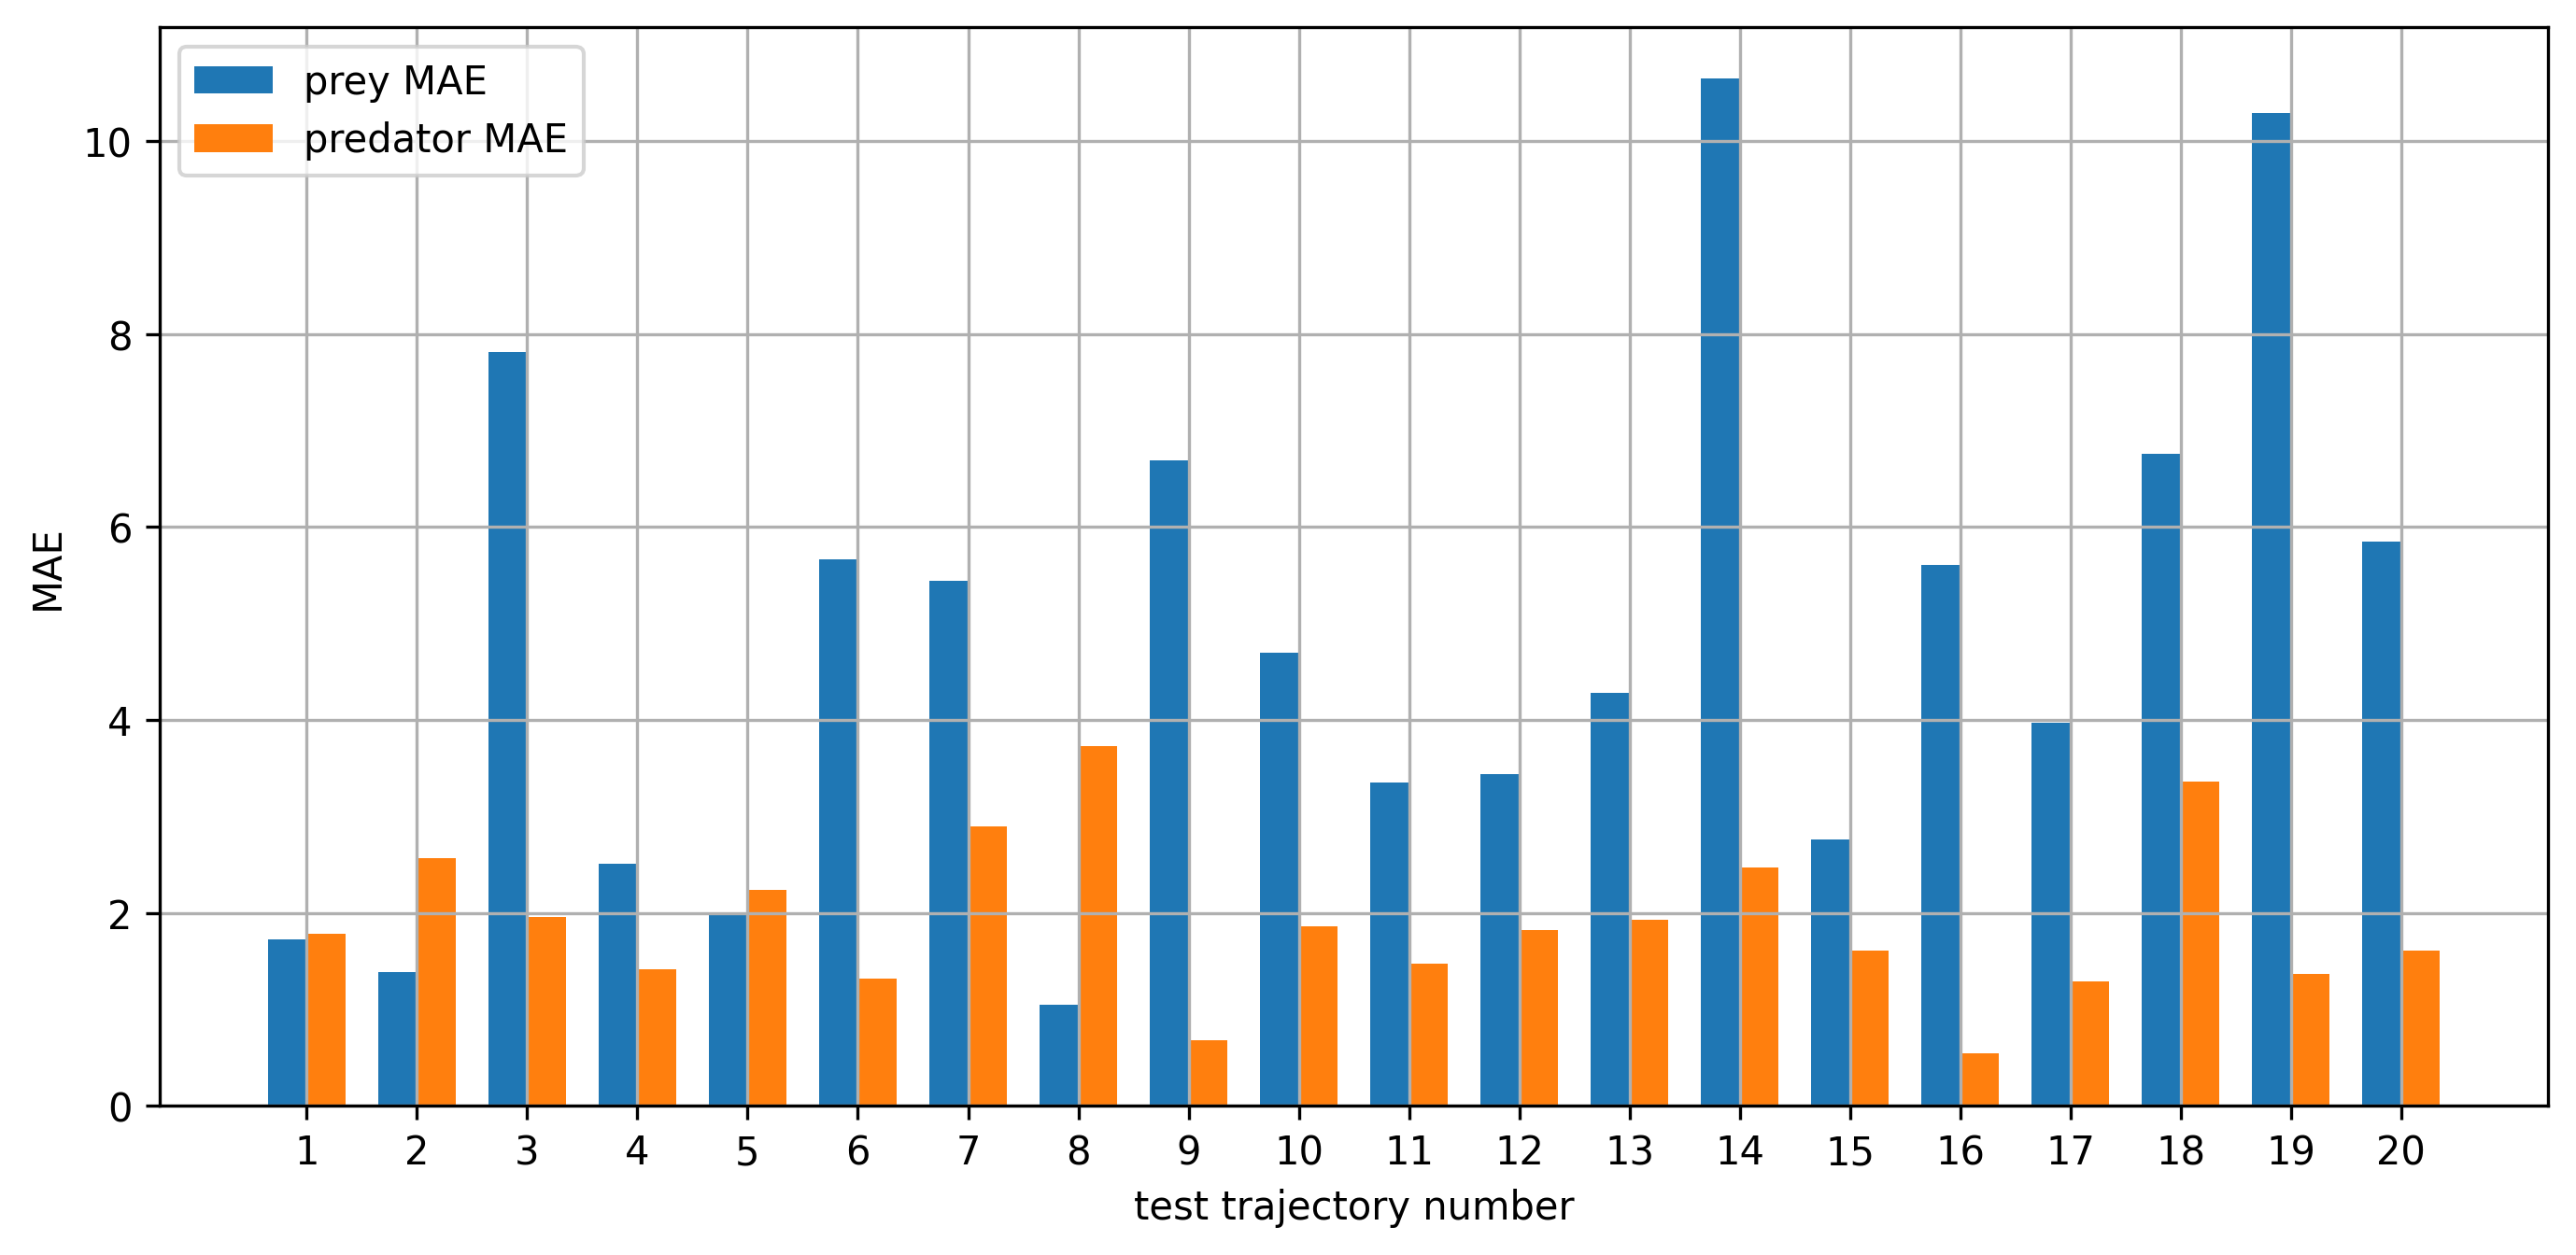

In [ ]:
# MAE over 20 trajectories

fig,ax = plt.subplots(1,1, figsize=(11,5))

fig.set_dpi(300)
bar_width = 0.35

N = np.linspace(1,20,20)
ax.bar(N - bar_width/2, mae_prey, bar_width, label='prey MAE')
ax.bar(N + bar_width/2, mae_pred, bar_width, label='predator MAE')

ax.set_xlabel('test trajectory number')
ax.set_ylabel('MAE')
ax.grid()
plt.xticks(range(1, 21))
plt.legend()
plt.show()

<ipython-input-22-352d577f5c8a>:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


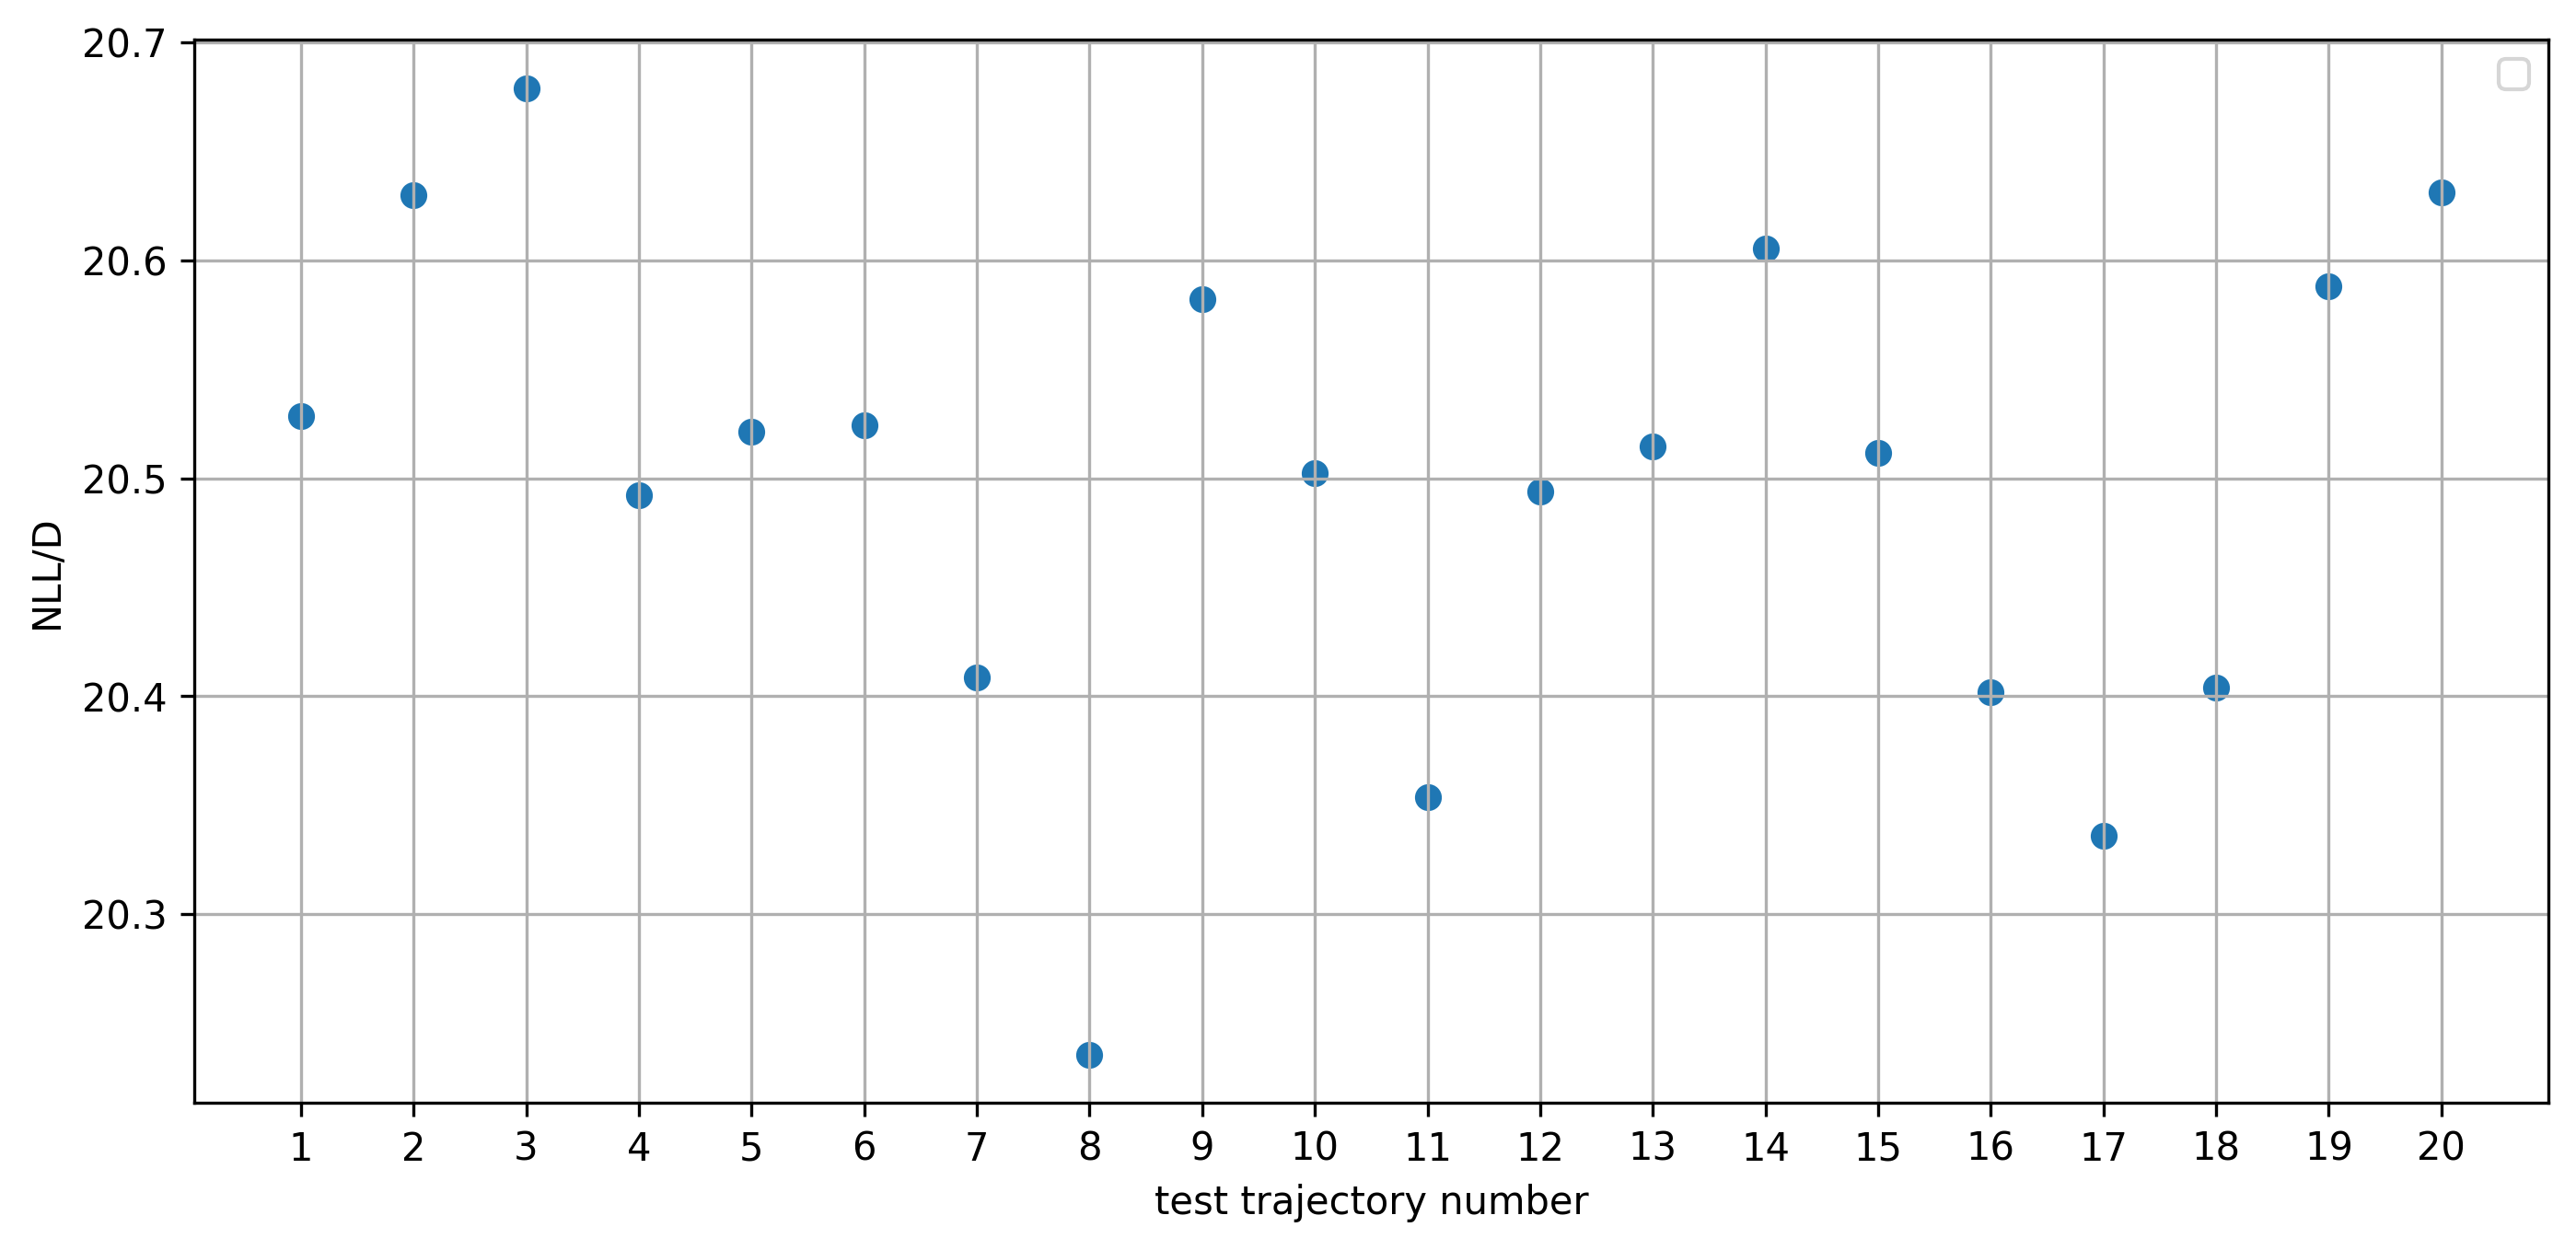

In [ ]:
# NLL
fig,ax = plt.subplots(1,1, figsize=(11,5))

fig.set_dpi(300)


N = np.linspace(1,20,20)
ax.scatter(N, np.array(nll))


ax.set_xlabel('test trajectory number')
ax.set_ylabel('NLL/D')
ax.grid()
plt.xticks(range(1, 21))
plt.legend()
plt.show()

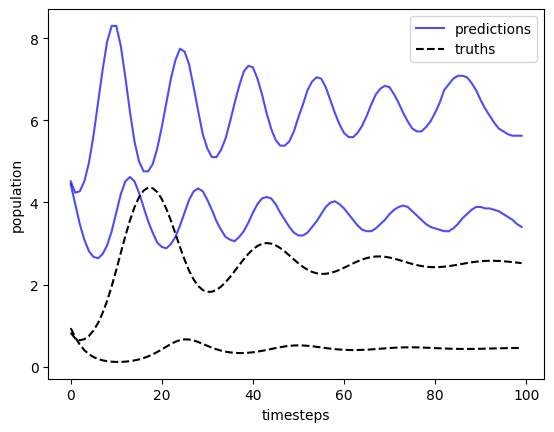

In [ ]:
# visualise predictions vs truths

index = 6

plt.plot(predictions[index][0], label='predictions', color='b', alpha=0.7)
plt.plot(predictions[index][1], color='b', alpha=0.7)

plt.plot(prey_all[index], color='black', linestyle='--')
plt.plot(predator_all[index], color='black',linestyle='--', label='truths')



plt.xlabel("timesteps")
plt.ylabel("population")
plt.legend()
plt.show()